In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


# 1. Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from pprint import pprint
import regex
import spacy
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import random
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Activation, Input, Dense, Dropout, BatchNormalization, \
LSTM, GRU, Bidirectional, Flatten, concatenate, Embedding, Reshape, GlobalAveragePooling1D, \
Attention, BatchNormalization
from keras.callbacks import EarlyStopping
from keras import optimizers, regularizers
from sklearn.metrics import plot_roc_curve, roc_curve, \
auc, precision_score, recall_score, confusion_matrix, \
classification_report, accuracy_score, f1_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta

nltk.download('universal_tagset')
nltk.download('punkt')
random.seed(1)

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/stock_prediction/data/All_News.csv')
df.drop(columns=[df.columns[0],df.columns[5]], axis=1, inplace=True)
df.shape

(5681, 5)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/stock_prediction/data/All_News_update.csv')
df1.drop(columns=[df1.columns[0],df1.columns[5]], axis=1, inplace=True)
df1.shape

(18, 5)

In [ ]:
df = df.append(df1)
df.shape

(5699, 5)

## Filter Company

In [ ]:
df = df[df['company_name'] == 'Google']
df.shape

(1391, 5)

## Remove Duplicates

In [ ]:
#remove duplicates
nb_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print('# duplicates: ', nb_rows - df.shape[0])

# duplicates:  1


## Missing Value

In [ ]:
#check null
def check_missing_values(row):
    """ functions that check and verifies if there are missing values in dataframe """
    counter = 0
    for element in row:
        if element == True:
            counter+=1
    return ("# Empty entries:", counter)

df.isnull().apply(lambda x: check_missing_values(x)).transpose()

,0,1
Date,# Empty entries:,0
Title,# Empty entries:,0
Url,# Empty entries:,0
Body,# Empty entries:,15
company_name,# Empty entries:,0


## Adjust Published Date

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.date
df.head()

,Date,Title,Url,Body,company_name
2710,2021-05-19,‘Privacy by design’: Google to give people mor...,https://www.theguardian.com/technology/2021/ma...,<p>Google is attempting a rebrand with a suite...,Google
2711,2021-04-28,Alphabet: revenue soars for Google owner as Co...,https://www.theguardian.com/technology/2021/ap...,"<p>Google’s parent company, Alphabet, more tha...",Google
2712,2021-04-28,Australia’s competition watchdog wants to redu...,https://www.theguardian.com/technology/2021/ap...,<p>People should be given a choice of apps oth...,Google
2713,2021-04-22,Apple and Google ‘hold data hostage’ and stifl...,https://www.theguardian.com/technology/2021/ap...,<p>Apple and Google “hold data hostage” from s...,Google
2714,2021-04-16,Google location data: what does Australian cou...,https://www.theguardian.com/technology/2021/ap...,<p>If you have ever used Google Maps on your p...,Google


In [ ]:
df['wday'] = pd.to_datetime(df['Date'], format='%Y-%m-%d').dt.dayofweek
df

,Date,Title,Url,Body,company_name,wday
2710,2021-05-19,‘Privacy by design’: Google to give people mor...,https://www.theguardian.com/technology/2021/ma...,<p>Google is attempting a rebrand with a suite...,Google,2
2711,2021-04-28,Alphabet: revenue soars for Google owner as Co...,https://www.theguardian.com/technology/2021/ap...,"<p>Google’s parent company, Alphabet, more tha...",Google,2
2712,2021-04-28,Australia’s competition watchdog wants to redu...,https://www.theguardian.com/technology/2021/ap...,<p>People should be given a choice of apps oth...,Google,2
2713,2021-04-22,Apple and Google ‘hold data hostage’ and stifl...,https://www.theguardian.com/technology/2021/ap...,<p>Apple and Google “hold data hostage” from s...,Google,3
2714,2021-04-16,Google location data: what does Australian cou...,https://www.theguardian.com/technology/2021/ap...,<p>If you have ever used Google Maps on your p...,Google,4
...,...,...,...,...,...,...
4096,2012-05-21,China adds conditions to approval of Google bi...,https://www.theguardian.com/technology/2012/ma...,<p>Authorities in China have put a surprising ...,Google,0
4097,2012-05-21,"Boot up: Windows' new look, Apple's Siri lawsu...",https://www.theguardian.com/technology/blog/20...,<p>A quick burst of 9 links for you to chew ov...,Google,0
4098,2012-05-18,Google+: still not as interesting as Pinterest...,https://www.theguardian.com/technology/blog/20...,<p>Away from all the hubbub over that <em>othe...,Google,4
4099,2012-05-18,"Boot up: web v apps, Google v France, the iPho...",https://www.theguardian.com/technology/blog/20...,<p>A quick burst of 8 links for you to chew ov...,Google,4


In [ ]:
df.groupby('wday').count()

,Date,Title,Url,Body,company_name
wday,,,,,
0,227,227,227,227,227
1,262,262,262,260,262
2,301,301,301,297,301
3,275,275,275,270,275
4,233,233,233,230,233
5,41,41,41,40,41
6,51,51,51,51,51


In [ ]:
def adjusted_date(row):
    if row['wday'] < 4 or row['wday'] == 6:
        return row['Date'] + timedelta(days=1)
    elif row['wday'] == 5:
        return row['Date'] + timedelta(days=2)
    else:
        return row['Date'] + timedelta(days=3)

In [ ]:
df['adjusted_date'] = df.apply(lambda row: adjusted_date(row), axis=1)
df

,Date,Title,Url,Body,company_name,wday,adjusted_date
2710,2021-05-19,‘Privacy by design’: Google to give people mor...,https://www.theguardian.com/technology/2021/ma...,<p>Google is attempting a rebrand with a suite...,Google,2,2021-05-20
2711,2021-04-28,Alphabet: revenue soars for Google owner as Co...,https://www.theguardian.com/technology/2021/ap...,"<p>Google’s parent company, Alphabet, more tha...",Google,2,2021-04-29
2712,2021-04-28,Australia’s competition watchdog wants to redu...,https://www.theguardian.com/technology/2021/ap...,<p>People should be given a choice of apps oth...,Google,2,2021-04-29
2713,2021-04-22,Apple and Google ‘hold data hostage’ and stifl...,https://www.theguardian.com/technology/2021/ap...,<p>Apple and Google “hold data hostage” from s...,Google,3,2021-04-23
2714,2021-04-16,Google location data: what does Australian cou...,https://www.theguardian.com/technology/2021/ap...,<p>If you have ever used Google Maps on your p...,Google,4,2021-04-19
...,...,...,...,...,...,...,...
4096,2012-05-21,China adds conditions to approval of Google bi...,https://www.theguardian.com/technology/2012/ma...,<p>Authorities in China have put a surprising ...,Google,0,2012-05-22
4097,2012-05-21,"Boot up: Windows' new look, Apple's Siri lawsu...",https://www.theguardian.com/technology/blog/20...,<p>A quick burst of 9 links for you to chew ov...,Google,0,2012-05-22
4098,2012-05-18,Google+: still not as interesting as Pinterest...,https://www.theguardian.com/technology/blog/20...,<p>Away from all the hubbub over that <em>othe...,Google,4,2012-05-21
4099,2012-05-18,"Boot up: web v apps, Google v France, the iPho...",https://www.theguardian.com/technology/blog/20...,<p>A quick burst of 8 links for you to chew ov...,Google,4,2012-05-21


In [ ]:
df.groupby('adjusted_date').count()[['Title']].sort_values(by=['Title'], ascending=False)

,Title
adjusted_date,
2015-08-12,7
2017-03-20,6
2013-06-03,5
2014-07-07,5
2014-01-31,5
...,...
2014-11-26,1
2014-11-27,1
2014-12-03,1


In [ ]:
df_news = df.groupby('adjusted_date')['Title'].apply(' '.join).reset_index()
df_news

,adjusted_date,Title
0,2012-05-21,Google+: still not as interesting as Pinterest...
1,2012-05-22,Google given last chance to outline how it wil...
2,2012-05-23,Google appoints Dennis Woodside to run Motorol...
3,2012-05-24,Robert Moog's 78th birthday celebrated in Goog...
4,2012-05-25,Google faced with a million requests a month t...
...,...,...
943,2021-04-19,Google location data: what does Australian cou...
944,2021-04-23,Apple and Google ‘hold data hostage’ and stifl...
945,2021-04-29,Alphabet: revenue soars for Google owner as Co...
946,2021-05-20,‘Privacy by design’: Google to give people mor...


In [ ]:
df_news.rename({'adjusted_date': 'Date'}, axis=1, inplace=True)
df_news

,Date,Title
0,2012-05-21,Google+: still not as interesting as Pinterest...
1,2012-05-22,Google given last chance to outline how it wil...
2,2012-05-23,Google appoints Dennis Woodside to run Motorol...
3,2012-05-24,Robert Moog's 78th birthday celebrated in Goog...
4,2012-05-25,Google faced with a million requests a month t...
...,...,...
943,2021-04-19,Google location data: what does Australian cou...
944,2021-04-23,Apple and Google ‘hold data hostage’ and stifl...
945,2021-04-29,Alphabet: revenue soars for Google owner as Co...
946,2021-05-20,‘Privacy by design’: Google to give people mor...


## Text Tokenization

In [ ]:
#decontract to not create token from special cases.
#For example, "won't" or " can't" can generate tokens as "wo", "ca" which are not removed by stopwords

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"let\'s", "let us", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#convert to lower case and decontract
df_news['text_decont'] = df_news['Title'].str.lower().apply(lambda x: decontracted(x))

#remove punctuation
df_news['text_no_punc'] = df_news['text_decont'].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))

df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          948 non-null    object
 1   Title         948 non-null    object
 2   text_decont   948 non-null    object
 3   text_no_punc  948 non-null    object
dtypes: object(4)
memory usage: 29.8+ KB


In [ ]:
# tokenize w/o preprocessing
df_news['tk'] = df_news['text_no_punc'].apply(lambda x: nltk.word_tokenize(x))
df_news.head()

,Date,Title,text_decont,text_no_punc,tk
0,2012-05-21,Google+: still not as interesting as Pinterest...,google+: still not as interesting as pinterest...,google still not as interesting as pinterest...,"[google, still, not, as, interesting, as, pint..."
1,2012-05-22,Google given last chance to outline how it wil...,google given last chance to outline how it wil...,google given last chance to outline how it wil...,"[google, given, last, chance, to, outline, how..."
2,2012-05-23,Google appoints Dennis Woodside to run Motorol...,google appoints dennis woodside to run motorol...,google appoints dennis woodside to run motorol...,"[google, appoints, dennis, woodside, to, run, ..."
3,2012-05-24,Robert Moog's 78th birthday celebrated in Goog...,robert moog is 78th birthday celebrated in goo...,robert moog is 78th birthday celebrated in goo...,"[robert, moog, is, 78th, birthday, celebrated,..."
4,2012-05-25,Google faced with a million requests a month t...,google faced with a million requests a month t...,google faced with a million requests a month t...,"[google, faced, with, a, million, requests, a,..."


# 2. TF-IDF

In [ ]:
def identity_tokenizer(text):
    return text

tfvec = TfidfVectorizer(lowercase=False, tokenizer=identity_tokenizer)
df_tfvec = tfvec.fit_transform(df_news.tk.tolist()).todense()

In [ ]:
len(tfvec.get_feature_names())

3665

In [ ]:
df_tfvec

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
df_tfidf = pd.DataFrame(df_tfvec)
df_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3625,3626,3627,3628,3629,3630,3631,3632,3633,3634,3635,3636,3637,3638,3639,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649,3650,3651,3652,3653,3654,3655,3656,3657,3658,3659,3660,3661,3662,3663,3664
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
temp = np.empty(df_tfidf.shape[0], dtype=object)
temp[:] = df_tfidf.values.tolist()

In [ ]:
df_temp = pd.DataFrame(temp, columns=['tfidf'])
df_temp

,tfidf
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
943,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
944,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
945,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
946,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
df_news = df_news.join(df_temp)
df_news.head()

,Date,Title,text_decont,text_no_punc,tk,tfidf
0,2012-05-21,Google+: still not as interesting as Pinterest...,google+: still not as interesting as pinterest...,google still not as interesting as pinterest...,"[google, still, not, as, interesting, as, pint...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2012-05-22,Google given last chance to outline how it wil...,google given last chance to outline how it wil...,google given last chance to outline how it wil...,"[google, given, last, chance, to, outline, how...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2012-05-23,Google appoints Dennis Woodside to run Motorol...,google appoints dennis woodside to run motorol...,google appoints dennis woodside to run motorol...,"[google, appoints, dennis, woodside, to, run, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2012-05-24,Robert Moog's 78th birthday celebrated in Goog...,robert moog is 78th birthday celebrated in goo...,robert moog is 78th birthday celebrated in goo...,"[robert, moog, is, 78th, birthday, celebrated,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,2012-05-25,Google faced with a million requests a month t...,google faced with a million requests a month t...,google faced with a million requests a month t...,"[google, faced, with, a, million, requests, a,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## Load Stock Price Data

In [ ]:
df_stock = pd.read_csv('/content/drive/MyDrive/stock_prediction/data/Stock Price - GOOG.csv', skiprows=1)
df_stock.head()

,Date,Close
0,5/18/2012 16:00:00,300.20
1,5/21/2012 16:00:00,307.05
2,5/22/2012 16:00:00,300.39
3,5/23/2012 16:00:00,304.73
4,5/24/2012 16:00:00,301.82


In [ ]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'], infer_datetime_format=True).dt.date

In [ ]:
df_stock = df_stock.set_index('Date').join(df_news.set_index('Date'))

In [ ]:
df_stock.reset_index(inplace=True)

## Replace NaN TI-IDF by Zero Vector

In [ ]:
def tfidf_zero(list_):
    if type(list_) == float:
        list_ = np.zeros(len(tfvec.get_feature_names()), dtype=float)
    else:
        list_ = np.array(list_)
    return list_

In [ ]:
df_stock['tfidf_new'] = df_stock['tfidf'].apply(lambda x: tfidf_zero(x))

In [ ]:
df_stock.reset_index(inplace=True)

In [ ]:
df_stock

,index,Date,Close,Title,text_decont,text_no_punc,tk,tfidf,tfidf_new
0,0,2012-05-18,300.20,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,2012-05-21,307.05,Google+: still not as interesting as Pinterest...,google+: still not as interesting as pinterest...,google still not as interesting as pinterest...,"[google, still, not, as, interesting, as, pint...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,2012-05-22,300.39,Google given last chance to outline how it wil...,google given last chance to outline how it wil...,google given last chance to outline how it wil...,"[google, given, last, chance, to, outline, how...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,2012-05-23,304.73,Google appoints Dennis Woodside to run Motorol...,google appoints dennis woodside to run motorol...,google appoints dennis woodside to run motorol...,"[google, appoints, dennis, woodside, to, run, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,2012-05-24,301.82,Robert Moog's 78th birthday celebrated in Goog...,robert moog is 78th birthday celebrated in goo...,robert moog is 78th birthday celebrated in goo...,"[robert, moog, is, 78th, birthday, celebrated,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...
2275,2275,2021-06-04,2451.76,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2276,2276,2021-06-07,2466.09,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2277,2277,2021-06-08,2482.85,France fines Google for abusing online adverti...,france fines google for abusing online adverti...,france fines google for abusing online adverti...,"[france, fines, google, for, abusing, online, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2278,2278,2021-06-09,2491.40,NaN,NaN,NaN,NaN,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# 3. Train-test split

In [ ]:
df_stock = df_stock.fillna('')

In [ ]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'], format='%Y-%m-%d')

train_data = df_stock[df_stock['Date'] < '2020-01-01'].copy()
val_data = df_stock[df_stock['Date'] < '2020-09-01'][df_stock['Date'] > '2019-12-31'].copy()
test_data = df_stock[df_stock['Date'] > '2020-08-31'].copy()

val_data = val_data.set_index('Date')
train_data = train_data.set_index('Date')
test_data = test_data.set_index('Date')

print('Training set:', train_data.shape[0], 'accounted for ',train_data.shape[0]/df_stock.shape[0]*100,'%')
print('Val set:', val_data.shape[0], 'accounted for ',val_data.shape[0]/df_stock.shape[0]*100,'%')
print('Test set:', test_data.shape[0], 'accounted for ',test_data.shape[0]/df_stock.shape[0]*100,'%')

Training set: 1917 accounted for  84.07894736842105 %
Val set: 168 accounted for  7.368421052631578 %
Test set: 195 accounted for  8.552631578947368 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


# 4. Historical Price
## Data normalization

In [ ]:
# Scaling the training set
transform_train = {}
transform_val = {}
transform_test = {}
scaled_aa = {}
scaler = {}

sc = MinMaxScaler(feature_range=(0,1))

aa = np.array(df_stock.Close)
aa = aa.reshape(aa.shape[0],1)

a0 = np.array(train_data.Close)
a1 = np.array(test_data.Close)
a2 = np.array(val_data.Close)

a0 = a0.reshape(a0.shape[0],1)
a1 = a1.reshape(a1.shape[0],1)
a2 = a2.reshape(a2.shape[0],1)

scaled_aa = sc.fit_transform(aa)

transform_train = sc.transform(a0)
transform_test = sc.transform(a1)
transform_val = sc.transform(a2)

scaler = sc
    
del aa
del a0
del a1
del a2

## Windowing Input Data

In [ ]:
#windowing size
n_lags = int(60)

trainset = {}
testset = {}
valset = {}
    
X_train = []
y_train = []
for i in range(n_lags,train_data.shape[0]):
    X_train.append(transform_train[i-n_lags:i])
    y_train.append(transform_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)
trainset["X"] = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
trainset["y"] = y_train

X_test = []
y_test = []    
for i in range(n_lags, test_data.shape[0]):
    X_test.append(transform_test[i-n_lags:i])
    y_test.append(transform_test[i])
X_test, y_test = np.array(X_test), np.array(y_test)
testset["X"] = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
testset["y"] = y_test

X_val = []
y_val = []    
for i in range(n_lags, val_data.shape[0]):
    X_val.append(transform_val[i-n_lags:i])
    y_val.append(transform_val[i])
X_val, y_val = np.array(X_val), np.array(y_val)
valset["X"] = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
valset["y"] = y_val

In [ ]:
# Check the shape (again) before start training
arr_buff = []
buff = {}
buff["X_train"] = trainset["X"].shape
buff["y_train"] = trainset["y"].shape
buff["X_test"] = testset["X"].shape
buff["y_test"] = testset["y"].shape
buff["X_val"] = valset["X"].shape
buff["y_val"] = valset["y"].shape
arr_buff.append(buff)

pd.DataFrame(arr_buff)

,X_train,y_train,X_test,y_test,X_val,y_val
0,"(1857, 60, 1)","(1857, 1)","(135, 60, 1)","(135, 1)","(108, 60, 1)","(108, 1)"


# 5. Word Embedding

In [ ]:
import gensim
from gensim.models import Word2Vec
#setting
vector_dim = 750
window_size = 5
min_count = 1
training_iter = 20

#model
word2vec_model = Word2Vec(sentences=df_news.tk.values, size=vector_dim, window=window_size, 
                          min_count=min_count, iter=training_iter)

In [ ]:
#save model in ASCII (word2vec) format
filename = '/content/drive/MyDrive/stock_prediction/GOOG/embedding_word2vec.txt'
word2vec_model.wv.save_word2vec_format(filename, binary=False)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#find the longest tweet and use its length as number of embedding features
maxlen = max([len(s.split()) for s in train_data.text_no_punc[n_lags:]])

#tokenizer, sequence & padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text_no_punc)
xtrain_word_index = tokenizer.word_index
xtrain_sequences = tokenizer.texts_to_sequences(train_data.text_no_punc[n_lags:])
news_train = pad_sequences(xtrain_sequences, maxlen, padding='pre')
news_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text_no_punc[n_lags:].str.lower())
                       ,maxlen, padding='pre')
news_val = pad_sequences(tokenizer.texts_to_sequences(val_data.text_no_punc[n_lags:].str.lower())
                       ,maxlen, padding='pre')

In [ ]:
maxlen

75

In [ ]:
news_train.shape

(1857, 75)

## Load Pre-trained Word Embedding

In [ ]:
#load embedding as a dict
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

# create a weight matrix for the Embedding layer from a loaded embedding
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, vector_dim))
    # step vocab, store vectors using the Tokenizer's integer mapping
    hits = 0
    misses = 0
    for word, i in vocab.items():
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            weight_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return weight_matrix, vocab_size

# load embedding from pre-trained embedding file
raw_embedding = load_embedding('/content/drive/MyDrive/stock_prediction/GOOG/embedding_word2vec.txt')

# get vectors in the right order
embedding_vectors, vocab_size = get_weight_matrix(raw_embedding, tokenizer.word_index)

Converted 3475 words (5 misses)


# 6. Seq2seq Model with Word2Vec

In [ ]:
%%time
# LSTM architecture
# FIRST BRANCH operates on the first input
# 1st layer with Dropout regularisation
lstm_input = Input(shape=(X_train.shape[1],1))
x = Bidirectional(GRU(units=60, return_sequences=True))(lstm_input)
x = Dropout(0.2)(x)

# 2nd LSTM layer
x = GRU(units=60)(x)
x = Dropout(0.2)(x)

lstm_branch = Model(inputs=lstm_input, outputs=x)

# SECOND BRANCH operates on the first input
embedding_layer = Embedding(vocab_size, vector_dim, weights=[embedding_vectors]
                            ,input_length=maxlen, trainable=False)
sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

y = Bidirectional(GRU(units=64, return_sequences=True))(embedded_sequences)
y = Dropout(0.2)(y)
y = GRU(units=64, return_sequences=True)(y)
y = Dropout(0.2)(y)
y = GRU(units=64)(y)
y = Dropout(0.2)(y)
news_branch = Model(inputs=sequence_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, news_branch.output], name='combined')
# Output layer
z = Dense(25)(combined)
z = Dense(1)(z)
multi_model = Model(inputs=[lstm_branch.input, news_branch.input], outputs=z)

# Compiling
multi_model.compile(optimizer='adam', loss='mean_squared_error')

CPU times: user 1.73 s, sys: 484 ms, total: 2.21 s
Wall time: 6.33 s


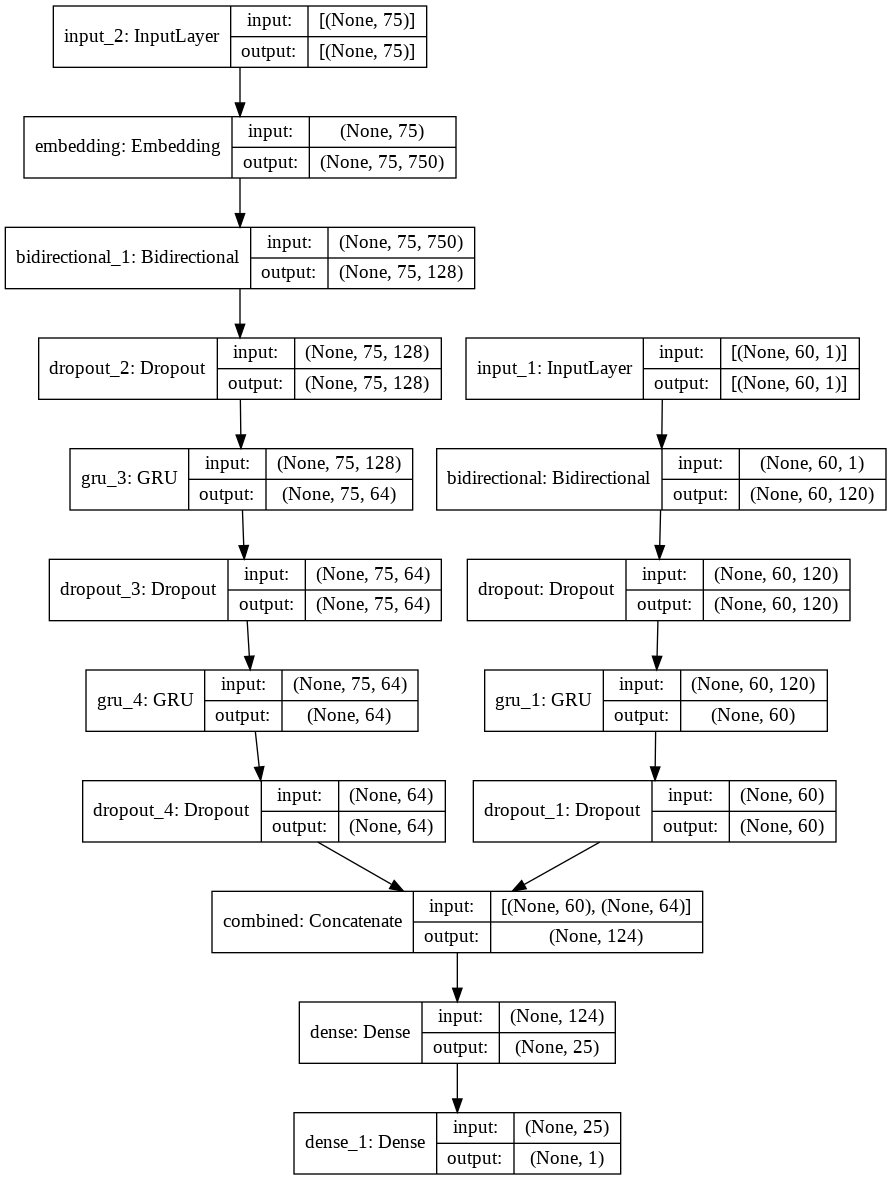

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(multi_model, show_shapes=True)

In [ ]:
from keras.callbacks import CSVLogger
logger_filename = '/content/drive/MyDrive/stock_prediction/GOOG/training_log_seq2seq_model.csv'

my_callback = [
               EarlyStopping(patience=5,monitor='val_loss'),
               CSVLogger(filename=logger_filename)

]

# training setting
epochs = 100
batch_size = 64

# Fitting to the training set
multi_model.fit([trainset['X'], news_train], trainset['y'], epochs=epochs, batch_size=batch_size, callbacks=my_callback
                              , validation_data=([valset['X'], news_val], valset['y']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
30/30 [==============================] - 10s 83ms/step - loss: 0.0342 - val_loss: 8.0892e-04
Epoch 2/100
30/30 [==============================] - 3s 83ms/step - loss: 0.0013 - val_loss: 5.4066e-04
Epoch 3/100
30/30 [==============================] - 2s 83ms/step - loss: 6.7933e-04 - val_loss: 4.4495e-04
Epoch 4/100
30/30 [==============================] - 2s 83ms/step - loss: 5.1291e-04 - val_loss: 4.6483e-04
Epoch 5/100
30/30 [==============================] - 2s 82ms/step - loss: 4.5339e-04 - val_loss: 3.2068e-04
Epoch 6/100
30/30 [==============================] - 2s 81ms/step - loss: 3.7887e-04 - val_loss: 1.9643e-04
Epoch 7/100
30/30 [==============================] - 2s 82ms/step - loss: 5.0843e-04 - val_loss: 1.8618e-04
Epoch 8/100
30/30 [==============================] - 2s 79ms/step - loss: 3.9957e-04 - val_loss: 2.9389e-04
Epoch 9/100
30/30 [==============================] - 2s 80ms/step - loss: 3.6127e-04 - val_loss: 2.6485e-04
Epoch 10/100
30/30 [===============

In [ ]:
multi_model.save('/content/drive/MyDrive/stock_prediction/GOOG/stock_pred_seq2seq_model.h5')

## Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

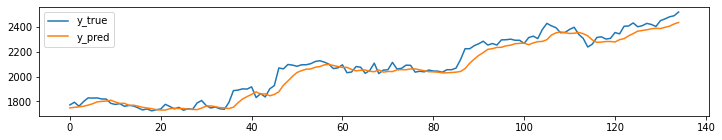

In [ ]:
def calculate_mse_multi(scaler, y_input, x_input, w2v):
    y_pred = multi_model.predict([x_input, w2v])
    MSE = mean_squared_error(y_input, y_pred)

    y_true = scaler.inverse_transform(y_input.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    real_mse = np.mean(np.square(y_true - y_pred))
    scaled_mse = real_mse/(np.max(y_true) - np.min(y_true)) * 100

    return MSE, scaled_mse, y_true, y_pred

train_MSE, train_scaled_mse, train_y, train_y_pred = calculate_mse_multi(scaler, trainset["y"], trainset["X"], news_train)
val_MSE, val_scaled_mse, val_y, val_y_pred = calculate_mse_multi(scaler, valset["y"], valset["X"], news_val)
test_MSE, test_scaled_mse, test_y, test_y_pred = calculate_mse_multi(scaler, testset["y"], testset["X"], news_test)

y_true = np.vstack((test_y))
y_pred = np.vstack((test_y_pred))


mse = {}
mse["train"] = train_MSE
mse["val"] = val_MSE
mse["test"] = test_MSE

scaled_mse = {}
scaled_mse["train"] = train_scaled_mse
scaled_mse["val"] = val_scaled_mse
scaled_mse["test"] = test_scaled_mse

pred_result = {}
pred_result["True"] = test_y
pred_result["Pred"] = test_y_pred

plt.figure(figsize=(12,2))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])

In [ ]:
mse

{'test': 0.0006059962611226178,
 'train': 5.348937530282932e-05,
 'val': 0.00022417470061638546}

In [ ]:
scaled_mse

{'test': 381.6935511955269,
 'train': 25.914568068527245,
 'val': 203.22957955009383}

## Prediction

**Definition:**

◦ **Rise (0):** CP of Today > CP of Yesterday , Change Rate > 1.5 %

◦ **Remain Stable (1):** Change Rate ≤ 1.5 %

◦ **Fall (2):** CP of Today < CP of Yesterday , Change Rate > 1.5 %

In [ ]:
pred_df = pd.DataFrame(pred_result['Pred'], columns=['Pred'])
pred_df['True'] = pred_result['True']
pred_df = pred_df.tail(5)
pred_df['His_True'] = pred_result['True'][-6:][:5]
pred_df['His_Pred'] = pred_result['Pred'][-6:][:5]
pred_df['Pred_change_rate'] = (pred_df['Pred'] - pred_df['His_Pred']).abs()/pred_df['His_Pred']*100
pred_df['True_change_rate'] = (pred_df['True'] - pred_df['His_True']).abs()/pred_df['His_True']*100
pred_df

,Pred,True,His_True,His_Pred,Pred_change_rate,True_change_rate
130,2387.811768,2451.76,2404.61,2390.098633,0.095681,1.960817
131,2398.353271,2466.09,2451.76,2387.811768,0.441471,0.584478
132,2407.072510,2482.85,2466.09,2398.353271,0.363551,0.679618
133,2424.833496,2491.40,2482.85,2407.072510,0.737867,0.344362
134,2437.500977,2521.60,2491.40,2424.833496,0.522406,1.212170


In [ ]:
def change_type_pred(row):
    if row['Pred'] > row['His_Pred'] and row['Pred_change_rate'] > 1.5:
        return 0
    elif row['Pred'] < row['His_Pred'] and row['Pred_change_rate'] > 1.5:
        return 2
    else:
        return 1

def change_type_true(row):
    if row['True'] > row['His_True'] and row['True_change_rate'] > 1.5:
        return 0
    elif row['True'] < row['His_True'] and row['True_change_rate'] > 1.5:
        return 2
    else:
        return 1

pred_df['Pred_change_type'] = pred_df.apply(lambda row : change_type_pred(row), axis=1)
pred_df['True_change_type'] = pred_df.apply(lambda row : change_type_true(row), axis=1)

In [ ]:
pred_df

,Pred,True,His_True,His_Pred,Pred_change_rate,True_change_rate,Pred_change_type,True_change_type
130,2387.811768,2451.76,2404.61,2390.098633,0.095681,1.960817,1,0
131,2398.353271,2466.09,2451.76,2387.811768,0.441471,0.584478,1,1
132,2407.072510,2482.85,2466.09,2398.353271,0.363551,0.679618,1,1
133,2424.833496,2491.40,2482.85,2407.072510,0.737867,0.344362,1,1
134,2437.500977,2521.60,2491.40,2424.833496,0.522406,1.212170,1,1


# 7. Baseline Model

In [ ]:
%%time
# The LSTM architecture
regressorBiLSTM = Sequential()
# 1st layer with Dropout regularisation
regressorBiLSTM.add(Bidirectional(GRU(units=60, return_sequences=True), input_shape=(X_train.shape[1],1)))
regressorBiLSTM.add(Dropout(0.2))

# 2nd LSTM layer
regressorBiLSTM.add(GRU(units=60))
regressorBiLSTM.add(Dropout(0.2))

# Output layer
regressorBiLSTM.add(Dense(25))
regressorBiLSTM.add(Dense(units=1))

# Compiling LSTM 
regressorBiLSTM.compile(optimizer='adam', loss='mean_squared_error')
regressorBiLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 60, 120)           22680     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 120)           0         
_________________________________________________________________
gru_6 (GRU)                  (None, 60)                32760     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1525      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 56,991
Trainable params: 56,991
Non-trainable params: 0
____________________________________________________

In [ ]:
logger_filename = '/content/drive/MyDrive/stock_prediction/GOOG/training_log_bilstm_model.csv'

my_callback = [
               EarlyStopping(patience=5,monitor='val_loss'),
               CSVLogger(filename=logger_filename)

]

# training setting
epochs = 100
batch_size = 64

# Fitting to the training set
regressorBiLSTM.fit(trainset['X'], trainset['y'], epochs=epochs, batch_size=batch_size, callbacks=my_callback
                              , validation_data=(valset['X'], valset['y']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
30/30 [==============================] - 1s 38ms/step - loss: 0.0123 - val_loss: 0.0030
Epoch 2/100
30/30 [==============================] - 1s 40ms/step - loss: 9.2008e-04 - val_loss: 4.8969e-04
Epoch 3/100
30/30 [==============================] - 1s 36ms/step - loss: 6.1395e-04 - val_loss: 3.5793e-04
Epoch 4/100
30/30 [==============================] - 1s 36ms/step - loss: 5.5362e-04 - val_loss: 4.2835e-04
Epoch 5/100
30/30 [==============================] - 1s 37ms/step - loss: 4.5800e-04 - val_loss: 1.8591e-04
Epoch 6/100
30/30 [==============================] - 1s 37ms/step - loss: 5.1586e-04 - val_loss: 2.3451e-04
Epoch 7/100
30/30 [==============================] - 1s 38ms/step - loss: 6.2299e-04 - val_loss: 2.7220e-04
Epoch 8/100
30/30 [==============================] - 1s 37ms/step - loss: 3.6549e-04 - val_loss: 1.6062e-04
Epoch 9/100
30/30 [==============================] - 1s 37ms/step - loss: 3.3419e-04 - val_loss: 1.6073e-04
Epoch 10/100
30/30 [================

In [ ]:
regressorBiLSTM.save('/content/drive/MyDrive/stock_prediction/GOOG/stock_pred_bilstm_model.h5')

## Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

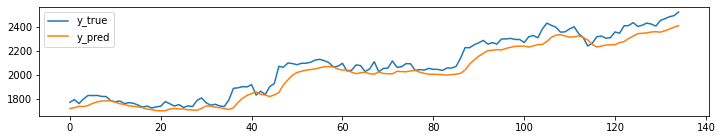

In [ ]:
def calculate_mse(scaler, y_input, x_input):
    y_pred = regressorBiLSTM.predict(x_input)
    MSE = mean_squared_error(y_input, y_pred)

    y_true = scaler.inverse_transform(y_input.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    real_mse = np.mean(np.square(y_true - y_pred))
    scaled_mse = real_mse/(np.max(y_true) - np.min(y_true)) * 100

    return MSE, scaled_mse, y_true, y_pred

train_MSE, train_scaled_mse, train_y, train_y_pred = calculate_mse(scaler, trainset["y"], trainset["X"])
val_MSE, val_scaled_mse, val_y, val_y_pred = calculate_mse(scaler, valset["y"], valset["X"])
test_MSE, test_scaled_mse, test_y, test_y_pred = calculate_mse(scaler, testset["y"], testset["X"])

y_true = np.vstack((test_y))
y_pred = np.vstack((test_y_pred))


mse = {}
mse["train"] = train_MSE
mse["val"] = val_MSE
mse["test"] = test_MSE

scaled_mse = {}
scaled_mse["train"] = train_scaled_mse
scaled_mse["val"] = val_scaled_mse
scaled_mse["test"] = test_scaled_mse

plt.figure(figsize=(12,2))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])

In [ ]:
mse

{'test': 0.001076285050257409,
 'train': 6.46982600012575e-05,
 'val': 0.00038791640171681734}

In [ ]:
scaled_mse

{'test': 677.909760733413,
 'train': 31.34506529170717,
 'val': 351.67248333552243}

# 8. Full-connected Network with TF-IDF
## Headlines Input Preparation

In [ ]:
train_data.head()

,index,Close,Title,text_decont,text_no_punc,tk,tfidf,tfidf_new
Date,,,,,,,,
2012-05-18,0,300.20,,,,,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-21,1,307.05,Google+: still not as interesting as Pinterest...,google+: still not as interesting as pinterest...,google still not as interesting as pinterest...,"[google, still, not, as, interesting, as, pint...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-22,2,300.39,Google given last chance to outline how it wil...,google given last chance to outline how it wil...,google given last chance to outline how it wil...,"[google, given, last, chance, to, outline, how...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-23,3,304.73,Google appoints Dennis Woodside to run Motorol...,google appoints dennis woodside to run motorol...,google appoints dennis woodside to run motorol...,"[google, appoints, dennis, woodside, to, run, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2012-05-24,4,301.82,Robert Moog's 78th birthday celebrated in Goog...,robert moog is 78th birthday celebrated in goo...,robert moog is 78th birthday celebrated in goo...,"[robert, moog, is, 78th, birthday, celebrated,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
train_news = np.matrix(train_data.tfidf_new[n_lags:].tolist())
#train_news = train_news.reshape(train_news.shape[0],1)

val_news = np.matrix(val_data.tfidf_new[n_lags:].tolist())
#val_news = val_news.reshape(val_news.shape[0],1)

test_news = np.matrix(test_data.tfidf_new[n_lags:].tolist())
#test_news = test_news.reshape(test_news.shape[0],1)

In [ ]:
print('News to train:',train_news.shape)
print('\nNews to test:',test_news.shape)
print('\nNews to val:',val_news.shape)

News to train: (1857, 3665)

News to test: (135, 3665)

News to val: (108, 3665)


## Model

In [ ]:
%%time
# LSTM architecture
# FIRST BRANCH operates on the first input
# 1st layer with Dropout regularisation
lstm_input = Input(shape=(X_train.shape[1],1))
x = Bidirectional(GRU(units=60, return_sequences=True))(lstm_input)
x = Dropout(0.2)(x)

# 2nd LSTM layer
x = GRU(units=60)(x)
x = Dropout(0.2)(x)

lstm_branch = Model(inputs=lstm_input, outputs=x)

# SECOND BRANCH operates on the first input
dense_input = Input(shape=(len(tfvec.get_feature_names()),))
y = Dense(50)(dense_input)
y = Dropout(0.2)(y)
technical_indicators_branch = Model(inputs=dense_input, outputs=y)

# combine the output of the two branches
combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')
# Output layer
z = Dense(25)(combined)
z = Dense(units=1)(z)
multi_model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

# Compiling
multi_model.compile(optimizer='adam', loss='mean_squared_error')

CPU times: user 577 ms, sys: 17 ms, total: 594 ms
Wall time: 594 ms


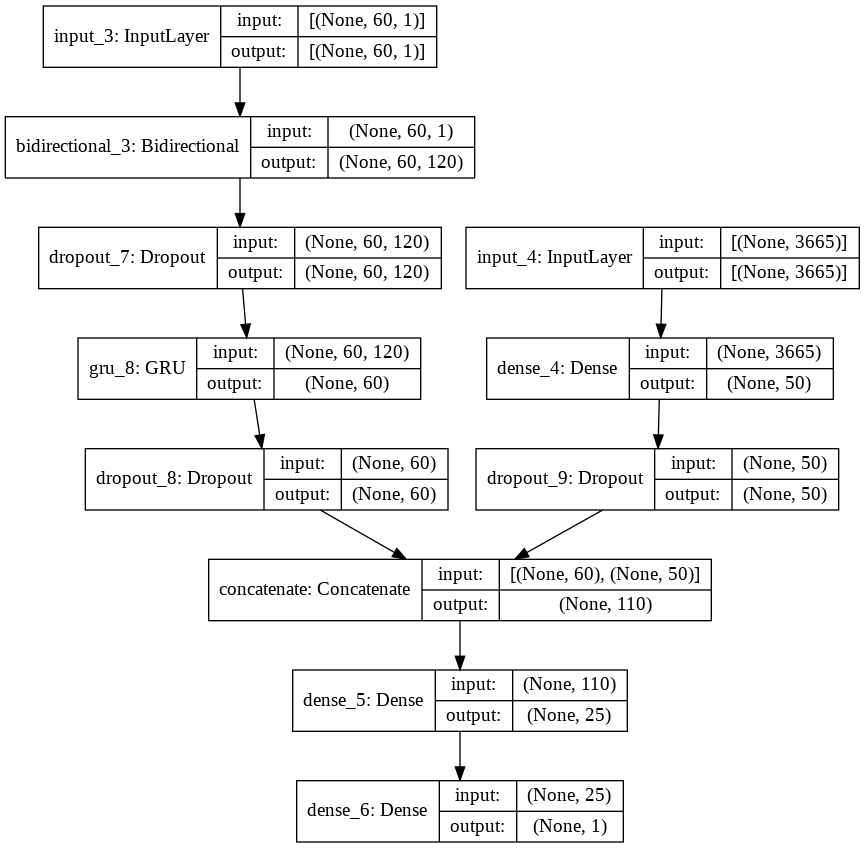

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(multi_model, show_shapes=True)

In [ ]:
from keras.callbacks import CSVLogger
logger_filename = '/content/drive/MyDrive/stock_prediction/GOOG/training_log_fc_model.csv'

my_callback = [
               EarlyStopping(patience=5,monitor='val_loss'),
               CSVLogger(filename=logger_filename)

]

# training setting
epochs = 100
batch_size = 64

# Fitting to the training set
multi_model.fit([trainset['X'], train_news], trainset['y'], epochs=epochs, batch_size=batch_size, callbacks=my_callback
                              , validation_data=([valset['X'], val_news], valset['y']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
30/30 [==============================] - 1s 41ms/step - loss: 0.0190 - val_loss: 7.6805e-04
Epoch 2/100
30/30 [==============================] - 1s 39ms/step - loss: 0.0012 - val_loss: 2.0203e-04
Epoch 3/100
30/30 [==============================] - 1s 40ms/step - loss: 7.1022e-04 - val_loss: 1.6837e-04
Epoch 4/100
30/30 [==============================] - 1s 40ms/step - loss: 4.7886e-04 - val_loss: 1.6728e-04
Epoch 5/100
30/30 [==============================] - 1s 40ms/step - loss: 4.5356e-04 - val_loss: 5.1617e-04
Epoch 6/100
30/30 [==============================] - 1s 40ms/step - loss: 3.9138e-04 - val_loss: 3.0784e-04
Epoch 7/100
30/30 [==============================] - 1s 40ms/step - loss: 3.7650e-04 - val_loss: 2.1089e-04
Epoch 8/100
30/30 [==============================] - 1s 39ms/step - loss: 3.5027e-04 - val_loss: 1.8272e-04
Epoch 9/100
30/30 [==============================] - 1s 39ms/step - loss: 3.2028e-04 - val_loss: 6.1034e-04


In [ ]:
multi_model.save('/content/drive/MyDrive/stock_prediction/GOOG/stock_pred_fc_model.h5')

## Evaluation

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply t

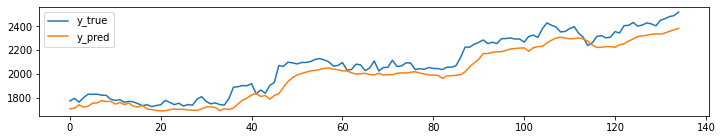

In [ ]:
def calculate_mse_multi(scaler, y_input, x_input, tfidf):
    y_pred = multi_model.predict([x_input, tfidf])
    MSE = mean_squared_error(y_input, y_pred)

    y_true = scaler.inverse_transform(y_input.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred)

    real_mse = np.mean(np.square(y_true - y_pred))
    scaled_mse = real_mse/(np.max(y_true) - np.min(y_true)) * 100

    return MSE, scaled_mse, y_true, y_pred

train_MSE, train_scaled_mse, train_y, train_y_pred = calculate_mse_multi(scaler, trainset["y"], trainset["X"], train_news)
val_MSE, val_scaled_mse, val_y, val_y_pred = calculate_mse_multi(scaler, valset["y"], valset["X"], val_news)
test_MSE, test_scaled_mse, test_y, test_y_pred = calculate_mse_multi(scaler, testset["y"], testset["X"], test_news)

y_true = np.vstack((test_y))
y_pred = np.vstack((test_y_pred))


mse = {}
mse["train"] = train_MSE
mse["val"] = val_MSE
mse["test"] = test_MSE

scaled_mse = {}
scaled_mse["train"] = train_scaled_mse
scaled_mse["val"] = val_scaled_mse
scaled_mse["test"] = test_scaled_mse

pred_result = {}
pred_result["True"] = test_y
pred_result["Pred"] = test_y_pred

plt.figure(figsize=(12,2))
plt.plot(y_true)
plt.plot(y_pred)
plt.legend(['y_true','y_pred'])

In [ ]:
mse

{'test': 0.0016429610859803783,
 'train': 8.946945778159691e-05,
 'val': 0.0006103355261211717}

In [ ]:
scaled_mse

{'test': 1034.8366280282535,
 'train': 43.34623809062547,
 'val': 553.3107921177262}

## Prediction

**Definition:**

◦ **Rise (0):** CP of Today > CP of Yesterday , Change Rate > 1.5 %

◦ **Remain Stable (1):** Change Rate ≤ 1.5 %

◦ **Fall (2):** CP of Today < CP of Yesterday , Change Rate > 1.5 %

In [ ]:
pred_df = pd.DataFrame(pred_result['Pred'], columns=['Pred'])
pred_df['True'] = pred_result['True']
pred_df = pred_df.tail(5)
pred_df['His_True'] = pred_result['True'][-6:][:5]
pred_df['His_Pred'] = pred_result['Pred'][-6:][:5]
pred_df['Pred_change_rate'] = (pred_df['Pred'] - pred_df['His_Pred']).abs()/pred_df['His_Pred']*100
pred_df['True_change_rate'] = (pred_df['True'] - pred_df['His_True']).abs()/pred_df['His_True']*100
pred_df

,Pred,True,His_True,His_Pred,Pred_change_rate,True_change_rate
130,2334.376221,2451.76,2404.61,2336.857178,0.106166,1.960817
131,2344.478027,2466.09,2451.76,2334.376221,0.432741,0.584478
132,2359.190674,2482.85,2466.09,2344.478027,0.627545,0.679618
133,2370.836426,2491.40,2482.85,2359.190674,0.493633,0.344362
134,2383.562256,2521.60,2491.40,2370.836426,0.536765,1.212170


In [ ]:
def change_type_pred(row):
    if row['Pred'] > row['His_Pred'] and row['Pred_change_rate'] > 1.5:
        return 0
    elif row['Pred'] < row['His_Pred'] and row['Pred_change_rate'] > 1.5:
        return 2
    else:
        return 1

def change_type_true(row):
    if row['True'] > row['His_True'] and row['True_change_rate'] > 1.5:
        return 0
    elif row['True'] < row['His_True'] and row['True_change_rate'] > 1.5:
        return 2
    else:
        return 1

pred_df['Pred_change_type'] = pred_df.apply(lambda row : change_type_pred(row), axis=1)
pred_df['True_change_type'] = pred_df.apply(lambda row : change_type_true(row), axis=1)

In [ ]:
pred_df

,Pred,True,His_True,His_Pred,Pred_change_rate,True_change_rate,Pred_change_type,True_change_type
130,2334.376221,2451.76,2404.61,2336.857178,0.106166,1.960817,1,0
131,2344.478027,2466.09,2451.76,2334.376221,0.432741,0.584478,1,1
132,2359.190674,2482.85,2466.09,2344.478027,0.627545,0.679618,1,1
133,2370.836426,2491.40,2482.85,2359.190674,0.493633,0.344362,1,1
134,2383.562256,2521.60,2491.40,2370.836426,0.536765,1.212170,1,1
